# Feedback notebook

This notebook will analyse the answers to the feedback questions

In [42]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import pandas as pd

## Load the data from the database

In [2]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [38]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891 entries, 0 to 4890
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4891 non-null   int64         
 1   created_at        4891 non-nu

## Number of chats per day (cummulative)

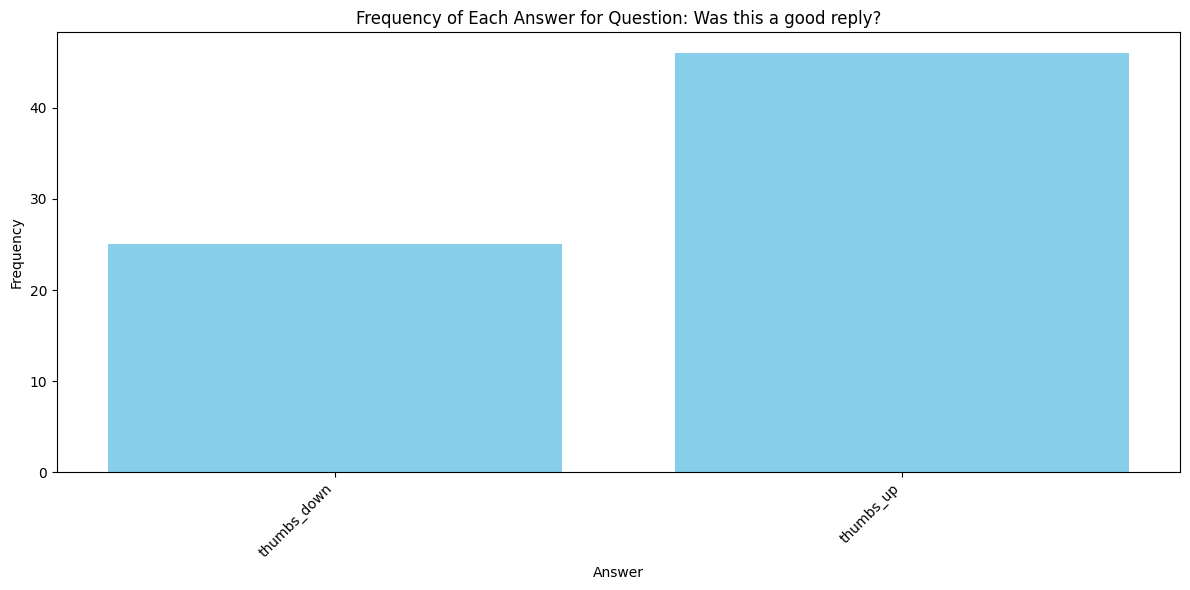

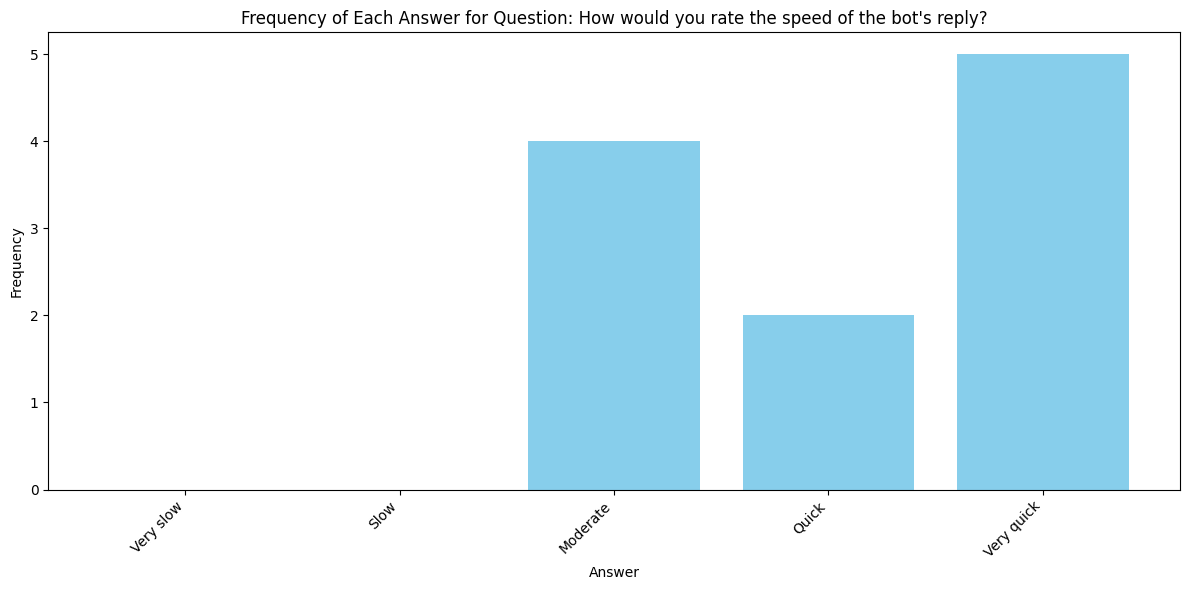

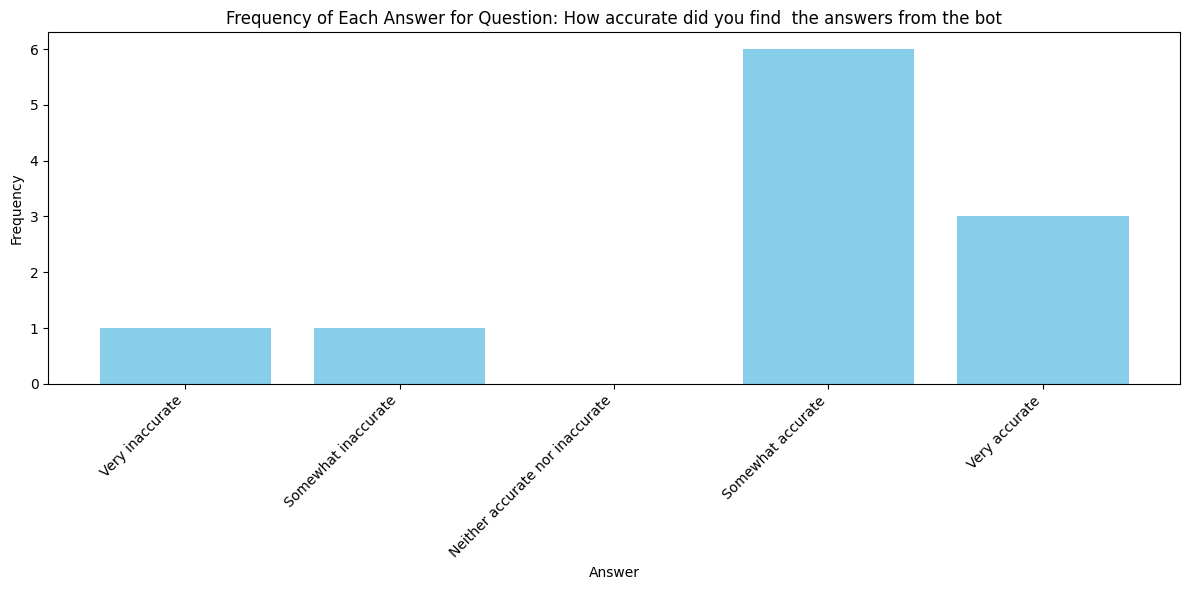

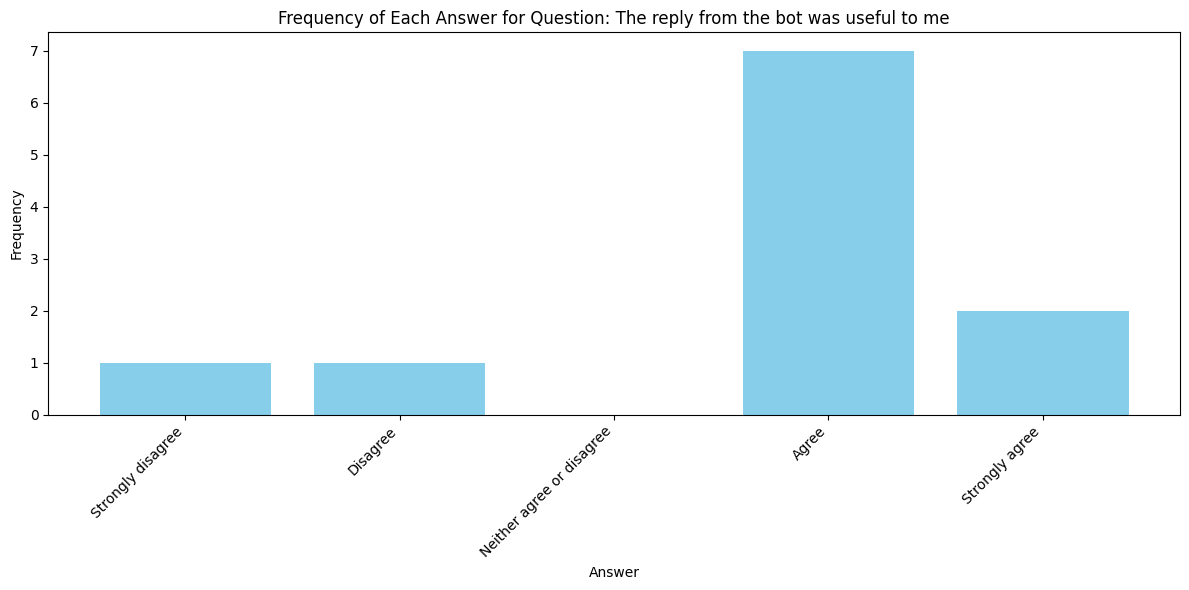

In [41]:
df_feedback_questions = dataframes['feedback_questions']
df_feedback = dataframes['feedback']

df_feedback['created_at'] = pd.to_datetime(df_feedback['created_at'])

df_merged_feedback = pd.merge(df_feedback, df_feedback_questions, left_on='feedback_question_id', right_on='id', how='left', suffixes=('', '_question'))

df_merged_feedback = df_merged_feedback[['feedback_question_id', 'answer', 'question_en']]
df_merged_feedback = df_merged_feedback[~df_merged_feedback['answer'].isin(['UNANSWERED'])]

questions = df_merged_feedback['question_en'].unique()

for question in questions:
    question_id = df_merged_feedback[df_merged_feedback['question_en'] == question]['feedback_question_id'].iloc[0]

    choices_data = df_feedback_questions[df_feedback_questions['id'] == question_id]['extra_data_en'].iloc[0]
    choices = choices_data["choices"]
    question_data = df_merged_feedback[df_merged_feedback['question_en'] == question]

    answer_frequency = question_data.groupby('answer').size().reindex(choices, fill_value=0).reset_index(name='count')

    plt.figure(figsize=(12, 6))
    plt.bar(answer_frequency['answer'], answer_frequency['count'], color='skyblue')
    plt.title(f'Frequency of Each Answer for Question: {question}')
    plt.xlabel('Answer')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.gca().invert_xaxis()
    plt.show()

## Filter per model

no answers to question Was this a good reply? for model meta-llama/Meta-Llama-3-8B-Instruct


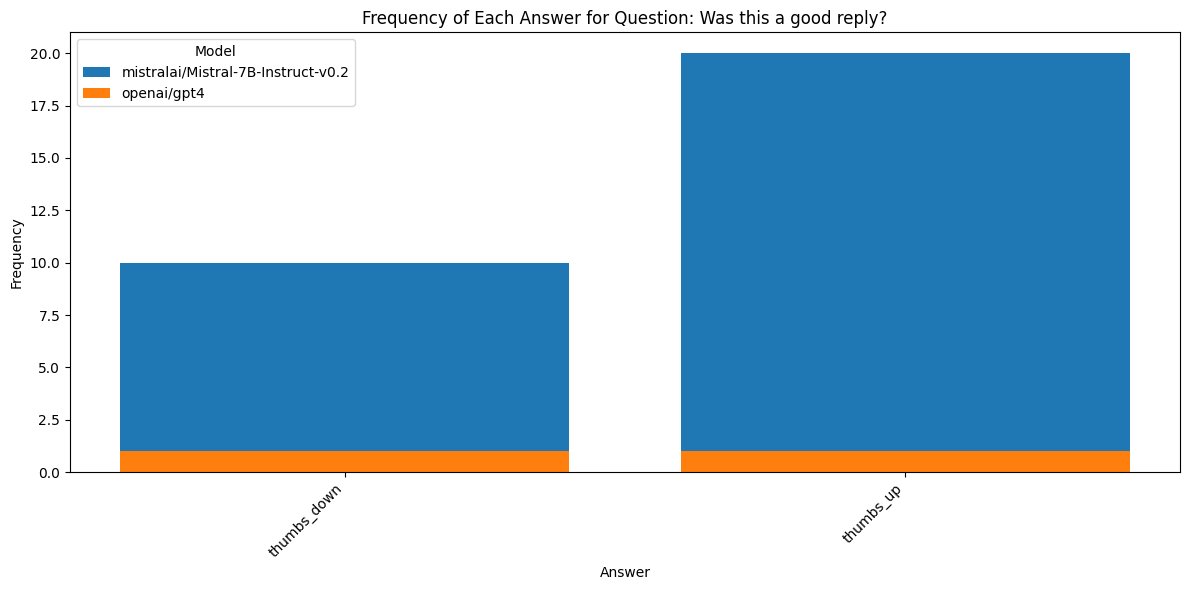

no answers to question How would you rate the speed of the bot's reply? for model meta-llama/Meta-Llama-3-8B-Instruct


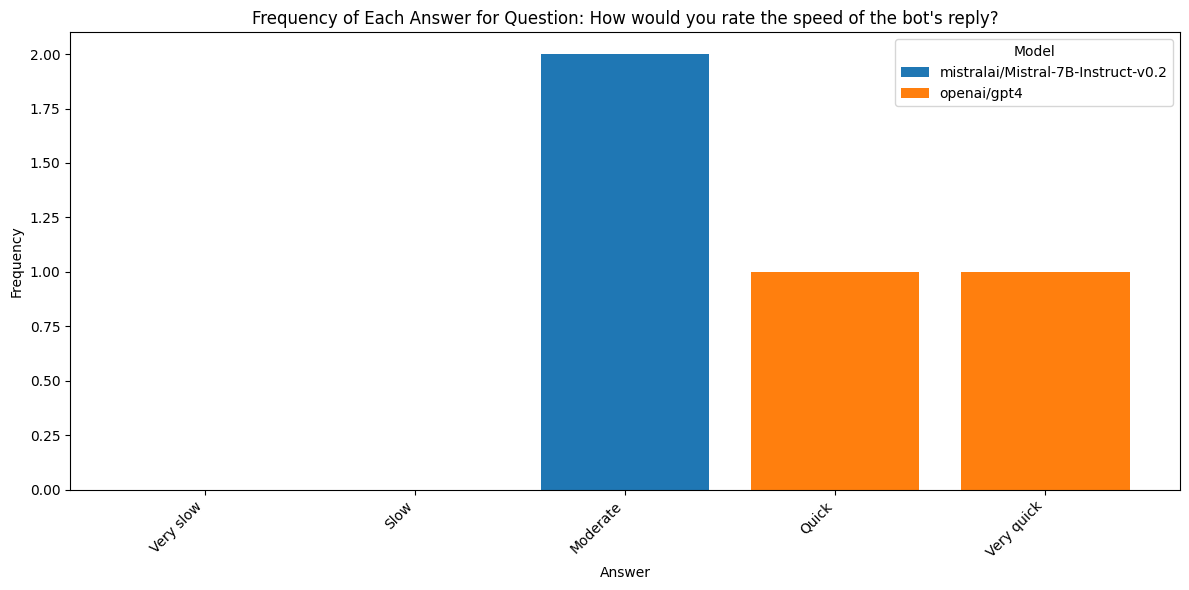

no answers to question How accurate did you find  the answers from the bot for model meta-llama/Meta-Llama-3-8B-Instruct


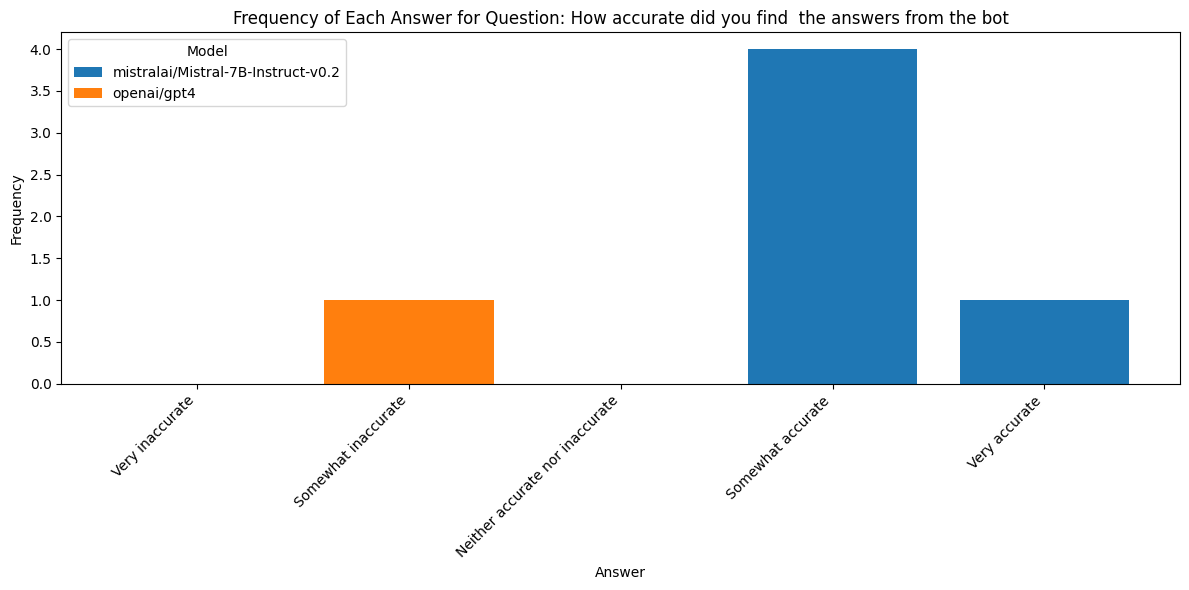

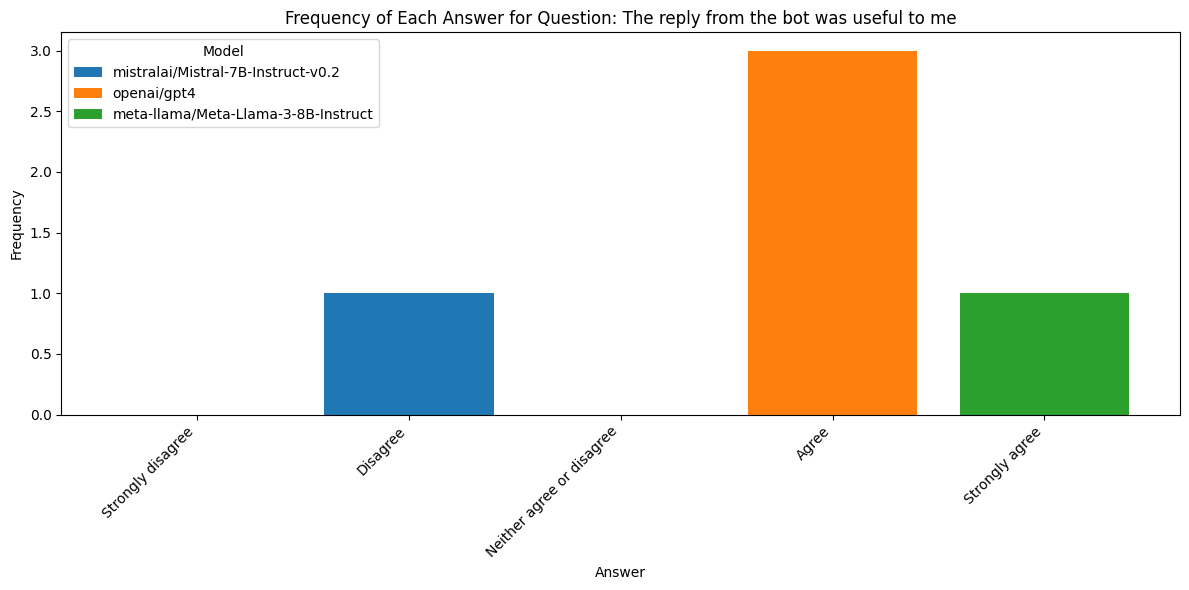

In [60]:
df_feedback_questions = dataframes['feedback_questions']
df_feedback = dataframes['feedback']
df_chats = dataframes['chats']

df_feedback['created_at'] = pd.to_datetime(df_feedback['created_at'])

df_merged_feedback = pd.merge(df_feedback, df_feedback_questions, left_on='feedback_question_id', right_on='id', how='left', suffixes=('', '_question'))

df_merged_feedback = df_merged_feedback[['feedback_question_id', 'answer', 'question_en', 'message_id']]
df_merged_feedback = df_merged_feedback[~df_merged_feedback['answer'].isin(['UNANSWERED'])]

df_merged_feedback = pd.merge(df_merged_feedback, df_chats[['id', 'llm_model_name']], left_on='message_id', right_on='id', how='left', suffixes=('', '_chat'))

df_merged_feedback = df_merged_feedback.dropna(subset=['llm_model_name'])

questions = df_merged_feedback['question_en'].unique()
models = df_merged_feedback['llm_model_name'].unique()

for question in questions:
    plt.figure(figsize=(12, 6))

    for model in models:
        model_data = df_merged_feedback[df_merged_feedback['llm_model_name'] == model]
        question_id = None
        try:
            question_id = model_data[model_data['question_en'] == question]['feedback_question_id'].iloc[0]
        except IndexError:
            print(f'no answers to question {question} for model {model}')
            continue

        choices_data = df_feedback_questions[df_feedback_questions['id'] == question_id]['extra_data_en'].iloc[0]
        choices = choices_data["choices"]
        question_data = model_data[model_data['question_en'] == question]

        answer_frequency = question_data.groupby('answer').size().reindex(choices, fill_value=0).reset_index(name='count')

        plt.bar(answer_frequency['answer'], answer_frequency['count'], label=model)

    plt.title(f'Frequency of Each Answer for Question: {question}')
    plt.xlabel('Answer')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.gca().invert_xaxis()
    plt.legend(title='Model')
    plt.show()